# Final version of Damage Identification

In [26]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from support import *
from support_damage_detection import *
from SPU_script import *

In [28]:
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import MDS
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from joblib import dump, load

## Load datasets

In [29]:
df_generated_pristine = get_VSSG_data("generated_small_u03", "pristine")
df_experimental = get_experimental_VSSG()
df_simulated_pristine = get_VSSG_data("simulated", "pristine")
df_simulated_damaged = get_damaged_VSSG_data("simulated")

df_test_numerical = pd.concat([df_simulated_pristine.sample(n=101, random_state=1),
                     df_simulated_damaged.sample(n=100, random_state=1)], ignore_index=True)

In [30]:
corrections = [{"sensor_nr": 1, "correction_angle": 0},
                         {"sensor_nr": 2, "correction_angle": 0.28},
                         {"sensor_nr": 3, "correction_angle": 1.08},
                         {"sensor_nr": 4, "correction_angle": -0.94},
                         {"sensor_nr": 5, "correction_angle": 0.65},
                         {"sensor_nr": 6, "correction_angle": 0.09},
                         {"sensor_nr": 7, "correction_angle": 0.67},
                         {"sensor_nr": 8, "correction_angle": 0.42},
                         {"sensor_nr": 9, "correction_angle": 0.78},
                        ]
df_corrected = correct_sensor_misalignment(df_experimental, corrections)

## Specifiy Model Parameters

In [42]:
default_direction = ["desc_x", "desc_y", "desc_xi"]

# NOTE: This setting works well in general
params_Hboost = {"max_iter": 300,
                 "max_depth": 40, #None
                 "max_leaf_nodes": 40, #default: 31
                 "min_samples_leaf": 50,
                 "loss": "absolute_error",
                 "l2_regularization": 0.5,
                 "random_state": 42,
                 }

# hyperparameter tuning
init_params = {
    "min_samples_leaf": 50,
    "loss": "absolute_error",
    # "quantile": 0.8,
    #"l2_regularization": 0,
}
param_grid = {"max_iter": [200, 300],
              "max_depth": [31, 45],
              "min_samples_leaf": [30, 50]}

# pre-processing pipeline
#pipeline = Pipeline([('standard_scaler', StandardScaler())])
pipeline = None

## Build Model

### Training procedure

In [43]:
grid_search = False

transformer = SensorGridDamageIdentification(direction=default_direction,
                                             spu_class=SPU,
                                             preprocess_pipeline=None,
                                             random_state=1)

if grid_search:
    transformer.hyperparameter_tuning(train_data=df_generated_pristine,
                                     reg_model=HistGradientBoostingRegressor,
                                      init_params=init_params,
                                      param_grid=param_grid)
    
df_train_results, r2_scores, mse_scores, mape_scores = transformer.fit(train_data=df_generated_pristine,
                                                          reg_model=HistGradientBoostingRegressor,
                                                          params=params_Hboost)

Regressor fitting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [02:34<00:00,  5.71s/it]


### Transform into "delta"-space

In [111]:
df_transform_results_experimental = transformer.transform(test_data=df_experimental, trained_model=None)
df_transform_results_corrected = transformer.transform(test_data=df_corrected, trained_model=None)
df_transform_results_simulated = transformer.transform(test_data=df_test_numerical, trained_model=None)
features = transformer.features

### Visulalize "delta"-space

#### experimental data and "benchmark" pristine data

D:\Masters_Thesis\work\notebooks\support.py:380: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, idx].set_xticklabels(formatted_lables)
D:\Masters_Thesis\work\notebooks\support.py:380: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, idx].set_xticklabels(formatted_lables)
D:\Masters_Thesis\work\notebooks\support.py:380: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, idx].set_xticklabels(formatted_lables)


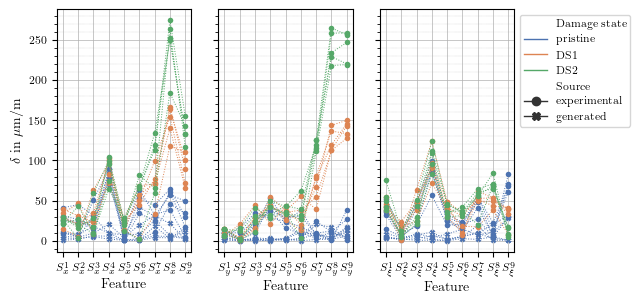

In [124]:
df_combined = pd.concat([df_transform_results_experimental, df_train_results.sample(n=5, random_state=0).reset_index(drop=True)],
                            ignore_index=True)
sns_plot_single_LC_sensor_strain(df_combined, hue="damage_state", mark="source",
                                 direction=default_direction,
                                 ylabel=r"$\delta$ in $\mu$m/m",
                                 figure_width_cm=15,
                                 figure_height_cm=8,
                                 save_figure=True,
                                 fn_extension="SPU_delta_space_exp")

#### corrected experimental data and "benchmark" pristine data

D:\Masters_Thesis\work\notebooks\support.py:380: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, idx].set_xticklabels(formatted_lables)
D:\Masters_Thesis\work\notebooks\support.py:380: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, idx].set_xticklabels(formatted_lables)
D:\Masters_Thesis\work\notebooks\support.py:380: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, idx].set_xticklabels(formatted_lables)


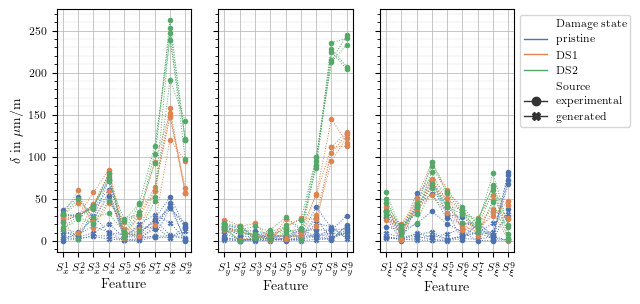

In [125]:
df_combined = pd.concat([df_transform_results_corrected, df_train_results.sample(n=5, random_state=0).reset_index(drop=True)],
                            ignore_index=True)
sns_plot_single_LC_sensor_strain(df_combined, hue="damage_state", mark="source",
                                 direction=default_direction,
                                 ylabel=r"$\delta$ in $\mu$m/m",
                                 figure_width_cm=15,
                                 figure_height_cm=8,
                                 save_figure=True,
                                 fn_extension="SPU_delta_space_compensated")

#### Dimensionality reduction via non-linear embedding of "delta" space and benchmark data

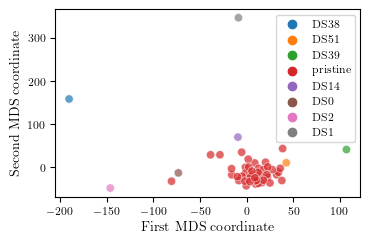

In [90]:
df_combined = pd.concat([df_transform_results_simulated.sample(n=10).reset_index(drop=True),
                         df_train_results.sample(n=40).reset_index(drop=True)],
                            ignore_index=True)
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(df_combined[features])
damage_states = df_combined["damage_state"]
plot_embedding(X_transformed, damage_states,
               figure_width_cm=10,
               fn_extension="SPU_numerical",
              save_figure=False)

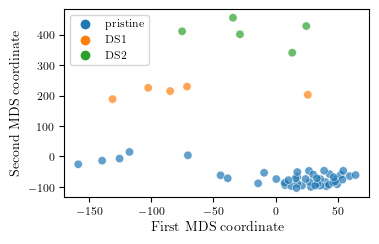

In [91]:
df_combined = pd.concat([df_transform_results_experimental, df_train_results.sample(n=40).reset_index(drop=True)],
                            ignore_index=True)
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(df_combined[features])
damage_states = df_combined["damage_state"]
plot_embedding(X_transformed, damage_states,
               figure_width_cm=10,
               fn_extension="SPU_experimental",
              save_figure=False)

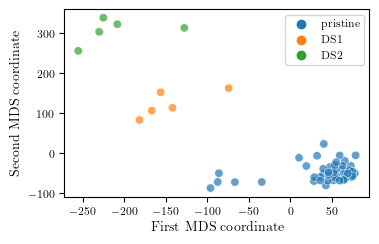

In [92]:
df_combined = pd.concat([df_transform_results_corrected, df_train_results.sample(n=40).reset_index(drop=True)],
                            ignore_index=True)
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(df_combined[features])
damage_states = df_combined["damage_state"]
plot_embedding(X_transformed, damage_states,
               figure_width_cm=10,
               fn_extension="SPU_numerical_corrected",
              save_figure=False)

## Perform damage identification

### **Training:** generated data (pristine)  
### **Testing:** simulated data (pristine & damaged)

----- Median distance ----- 
Accuracy: 0.975
Balanced accuracy: 0.975
F1 Score: 0.9743589743589743
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       100
           1       1.00      0.95      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

confusion matrix components:
True Positive (TP): 95
False Positive (FP): 0
False Negative (FN): 5
True Negative (TN): 100
-----  End of Report ----- 



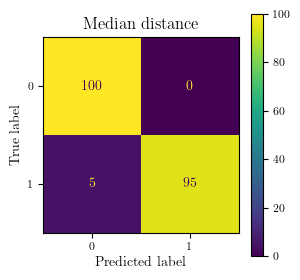

In [93]:
y_pred, y_test, damage_index = transformer.predict(df_train_results, df_transform_results_simulated, margin=0.3)

# evaluate classification
clf_results = {"Median distance": {"y_true": y_test, "y_pred": y_pred, "y_score": None}}
show_clf_result_metrics(clf_results, show_confusion_matrices=True)

In [94]:
classified_labels = get_classified_labels(y_test, y_pred, damage_params=True)
classified_labels["FN"]

,index,y_pred,loadcase,damage_state,y_true,source,x,y,radius
105,105,0,373,DS51,1,simulated,37.09,20.45,5.03
136,136,0,373,DS45,1,simulated,192.50,86.14,6.54
165,165,0,744,DS51,1,simulated,37.09,20.45,5.03
180,180,0,856,DS45,1,simulated,192.50,86.14,6.54
182,182,0,117,DS45,1,simulated,192.50,86.14,6.54


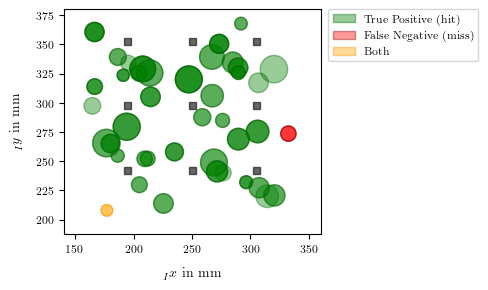

In [95]:
plot_classified_damages(classified_labels,
                        figure_width_cm=12,
                        figure_height_cm=None,
                        fn_extension="SPU_numerical", 
                        save_figure=False)

#### Show distribution of damage indices

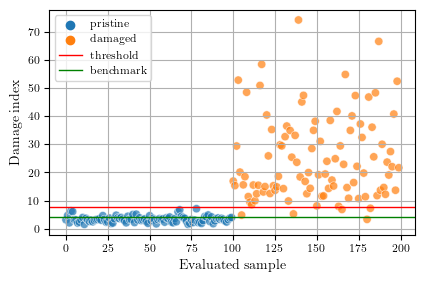

In [96]:
scatter_damage_index(damage_index, y_test, transformer.threshold, transformer.benchmark,
                     n=None, xticks=False,
                     figure_width_cm=12,
                     figure_height_cm=None,
                     fn_extension="SPU_numerical",
                     save_figure=False)

#### Soft localization through "delta" heat map

The representation of the prediction errors of each sensor direction / coil, suggests to visualize this data with a heat map. The heat map interpolates the errors at the sensor positions, assuming an error of 0 at the submodel edges. All three measurement directions are summed up to gain a meaningful representation of the approximate error location.
This approach can be demonstrated very well with the simulated benchmark test set.

In [109]:
df_transform_results_simulated.loc[df_transform_results_simulated["damage_state"] != "pristine", ["loadcase", "damage_state"]].head(10)

,loadcase,damage_state
101,255,DS12
102,769,DS32
103,382,DS1
104,222,DS38
105,798,DS35
106,373,DS51
107,119,DS25
108,410,DS17
109,46,DS29
110,932,DS41


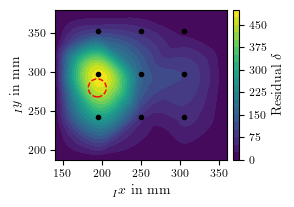

In [98]:
from support import plot_delta_heat_map
# select specific transformed sample
damage_state = "DS29"
load_case = 46 

df = df_transform_results_simulated
df_sample = df[(df["damage_state"] == damage_state) & (df["loadcase"] == load_case)]

plot_delta_heat_map(df_sample, direction=["desc_x", "desc_y", "desc_xi"], custom_axis_scaling=None,
                    cbar_label=r"Residual $\delta$",
                    figure_width_cm=8,
                    fn_extension="SPU",
                    show_damage=True,
                   save_figure=False)

### **Training:** generated data (pristine)  
### **Testing:** experimental data (pristine & damaged)

----- Median distance ----- 
Accuracy: 1.0
Balanced accuracy: 1.0
F1 Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        10

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

confusion matrix components:
True Positive (TP): 10
False Positive (FP): 0
False Negative (FN): 0
True Negative (TN): 4
-----  End of Report ----- 



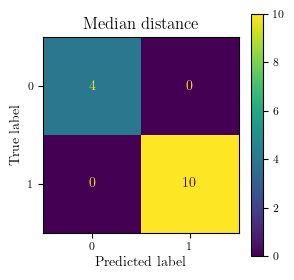

In [99]:
y_pred, y_test, damage_index = transformer.predict(df_train_results, df_transform_results_experimental, margin=0.3)

# evaluate classification
clf_results = {"Median distance": {"y_true": y_test, "y_pred": y_pred, "y_score": None}}
show_clf_result_metrics(clf_results, show_confusion_matrices=True)

In [110]:
classified_labels = get_classified_labels(y_test, y_pred, damage_params=True)
classified_labels["TP"]

,index,y_pred,loadcase,damage_state,y_true,source,x,y,radius
4,4,1,814,DS1,1,experimental,105.0,32.5,6.25
5,5,1,984,DS1,1,experimental,105.0,32.5,6.25
6,6,1,985,DS1,1,experimental,105.0,32.5,6.25
7,7,1,999,DS1,1,experimental,105.0,32.5,6.25
8,8,1,876,DS1,1,experimental,105.0,32.5,6.25
9,9,1,814,DS2,1,experimental,105.0,32.5,9.50
10,10,1,984,DS2,1,experimental,105.0,32.5,9.50
11,11,1,985,DS2,1,experimental,105.0,32.5,9.50
12,12,1,999,DS2,1,experimental,105.0,32.5,9.50
13,13,1,876,DS2,1,experimental,105.0,32.5,9.50


In [101]:
#plot_classified_damages(classified_labels, save_figure=False)

#### Show distribution of damage indices

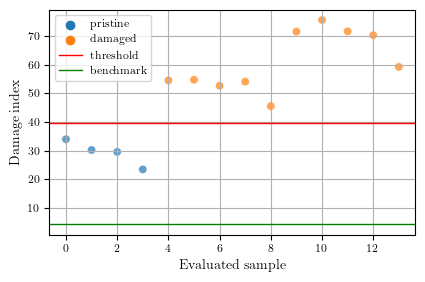

In [102]:
scatter_damage_index(damage_index, y_test, transformer.threshold, transformer.benchmark,
                     n=None, xticks=False,
                     figure_width_cm=12,
                     figure_height_cm=None,
                     fn_extension="SPU_experimental",
                     save_figure=True)

#### Soft localization through "delta" heat map

In [103]:
df_transform_results_experimental.loc[df_transform_results_experimental["damage_state"] != "pristine", ["loadcase", "damage_state"]].head(5)

,loadcase,damage_state
5,814,DS1
6,984,DS1
7,985,DS1
8,999,DS1
9,876,DS1


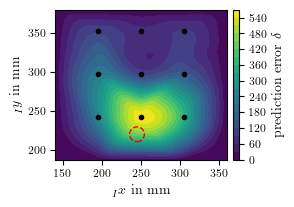

In [106]:
# select specific transformed sample
damage_state = "DS2"
load_case = 814 

df = df_transform_results_experimental
df_sample = df[(df["damage_state"] == damage_state) & (df["loadcase"] == load_case)]

plot_delta_heat_map(df_sample, direction=["desc_x", "desc_y", "desc_xi"], custom_axis_scaling=None,
                    figure_width_cm=8,
                    fn_extension="SPU",
                    show_damage=True,
                   save_figure=True)

### **Training:** generated data (pristine)  
### **Testing:** corrected experimental data (pristine & damaged)

----- Median distance ----- 
Accuracy: 1.0
Balanced accuracy: 1.0
F1 Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        10

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

confusion matrix components:
True Positive (TP): 10
False Positive (FP): 0
False Negative (FN): 0
True Negative (TN): 4
-----  End of Report ----- 



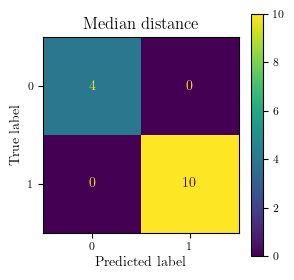

In [68]:
y_pred, y_test, damage_index = transformer.predict(df_train_results, df_transform_results_corrected, margin=0.2)

# evaluate classification
clf_results = {"Median distance": {"y_true": y_test, "y_pred": y_pred, "y_score": None}}
show_clf_result_metrics(clf_results, show_confusion_matrices=True)

In [69]:
classified_labels = get_classified_labels(y_test, y_pred, damage_params=True)
classified_labels["FP"]

,index,y_pred,loadcase,damage_state,y_true,source,x,y,radius


In [70]:
#plot_classified_damages(classified_labels, save_figure=False)

#### Show distribution of damage indices

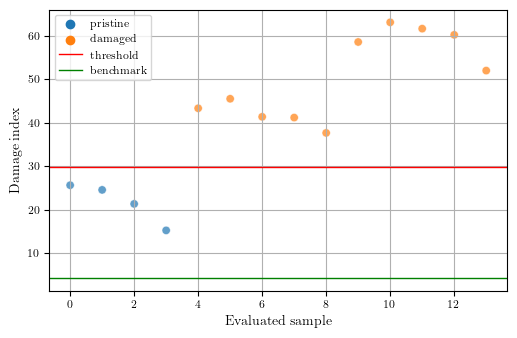

In [71]:
scatter_damage_index(damage_index, y_test, transformer.threshold, transformer.benchmark,
                     n=None, xticks=False,
                     figure_width_cm=15,
                     figure_height_cm=None,
                     fn_extension="SPU_experimental_corrected",
                     save_figure=False)

#### Soft localization through "delta" heat map

In [72]:
df_transform_results_corrected.loc[df_transform_results_corrected["damage_state"] != "pristine", ["loadcase", "damage_state"]].head(5)

,loadcase,damage_state
5,814,DS1
6,984,DS1
7,985,DS1
8,999,DS1
9,876,DS1


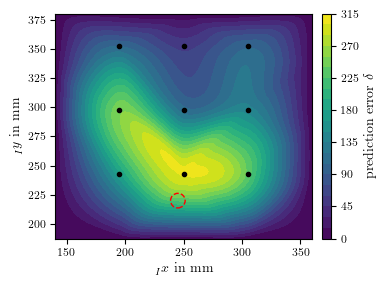

In [73]:
# select specific transformed sample
damage_state = "DS1"
load_case = 814 

df = df_transform_results_experimental
df_sample = df[(df["damage_state"] == damage_state) & (df["loadcase"] == load_case)]

plot_delta_heat_map(df_sample, direction=["desc_x", "desc_y", "desc_xi"], custom_axis_scaling=None,
                    figure_width_cm=12,
                    fn_extension="SPU",
                    show_damage=True)

### **Training:** simulated data (pristine)  
### **Testing:** experimental data (pristine & damaged)

### Training procedure - simulated data (pristine)

In [74]:
grid_search = False

transformer_sim = SensorGridDamageIdentification(direction=default_direction,
                                             spu_class=SPU,
                                             preprocess_pipeline=None,
                                             random_state=1)

df_train_results_sim, r2_scores_sim, mse_scores_sim, mape_scores_sim = transformer_sim.fit(train_data=df_simulated_pristine,
                                                          reg_model=HistGradientBoostingRegressor,
                                                          params=params_Hboost)

Regressor fitting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:51<00:00,  1.91s/it]


### Transform into "delta"-space

In [75]:
df_transform_results_experimental = transformer_sim.transform(test_data=df_experimental, trained_model=None)
df_transform_results_corrected = transformer_sim.transform(test_data=df_corrected, trained_model=None)
features = transformer.features

### Visulalize "delta"-space (Trained on: simulated pristine)

#### experimental data and "benchmark" pristine data

D:\Masters_Thesis\work\notebooks\support.py:380: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, idx].set_xticklabels(formatted_lables)
D:\Masters_Thesis\work\notebooks\support.py:380: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, idx].set_xticklabels(formatted_lables)
D:\Masters_Thesis\work\notebooks\support.py:380: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, idx].set_xticklabels(formatted_lables)


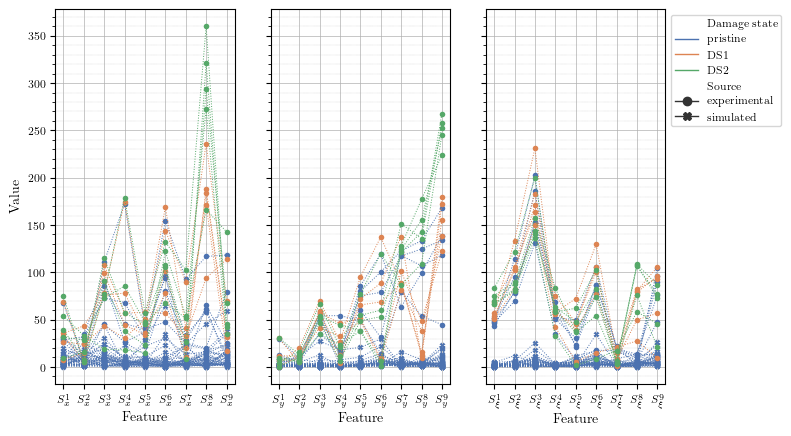

In [76]:
df_combined = pd.concat([df_transform_results_experimental, df_train_results_sim.sample(n=40).reset_index(drop=True)],
                            ignore_index=True)
sns_plot_single_LC_sensor_strain(df_combined, hue="damage_state", mark="source",
                                 direction=default_direction,
                                 figure_width_cm=20,
                                 save_figure=False,
                                 fn_extension="")

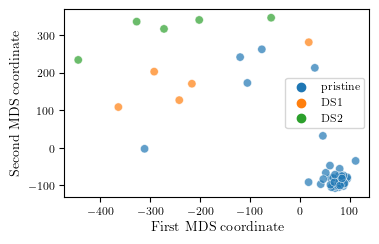

In [77]:
df_combined = pd.concat([df_transform_results_experimental, df_train_results_sim.sample(n=40).reset_index(drop=True)],
                            ignore_index=True)
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(df_combined[features])
damage_states = df_combined["damage_state"]
plot_embedding(X_transformed, damage_states,
               figure_width_cm=10,
               fn_extension="SPU_experimental",
              save_figure=False)

----- Median distance ----- 
Accuracy: 0.7857142857142857
Balanced accuracy: 0.85
F1 Score: 0.8235294117647058
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.70      0.82        10

    accuracy                           0.79        14
   macro avg       0.79      0.85      0.78        14
weighted avg       0.88      0.79      0.80        14

confusion matrix components:
True Positive (TP): 7
False Positive (FP): 0
False Negative (FN): 3
True Negative (TN): 4
-----  End of Report ----- 



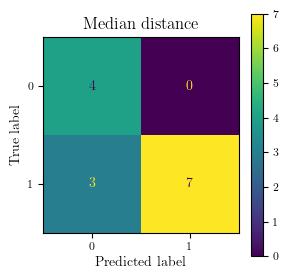

In [78]:
y_pred, y_test, damage_index = transformer_sim.predict(df_train_results_sim, df_transform_results_experimental, margin=0.3)

# evaluate classification
clf_results = {"Median distance": {"y_true": y_test, "y_pred": y_pred, "y_score": None}}
show_clf_result_metrics(clf_results, show_confusion_matrices=True)

In [79]:
classified_labels = get_classified_labels(y_test, y_pred, damage_params=True)
classified_labels["FN"]

,index,y_pred,loadcase,damage_state,y_true,source,x,y,radius
6,6,0,985,DS1,1,experimental,105.0,32.5,6.25
7,7,0,999,DS1,1,experimental,105.0,32.5,6.25
8,8,0,876,DS1,1,experimental,105.0,32.5,6.25


In [80]:
#plot_classified_damages(classified_labels, save_figure=False)

#### Show distribution of damage indices

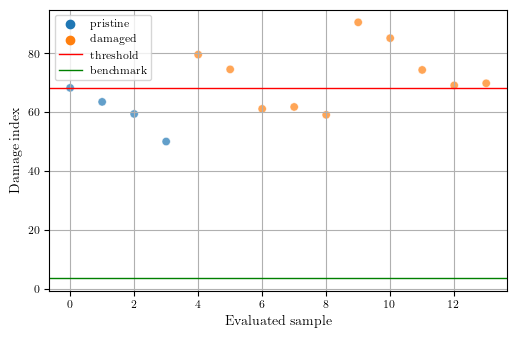

In [81]:
scatter_damage_index(damage_index, y_test, transformer_sim.threshold, transformer_sim.benchmark,
                     n=None, xticks=False,
                     figure_width_cm=15,
                     figure_height_cm=None,
                     fn_extension="SPU_trained_simulated",
                     save_figure=False)

#### Soft localization through "delta" heat map

In [62]:
df_transform_results_experimental.loc[df_transform_results_experimental["damage_state"] != "pristine", ["loadcase", "damage_state"]].head(5)

,loadcase,damage_state
5,814,DS1
6,984,DS1
7,985,DS1
8,999,DS1
9,876,DS1


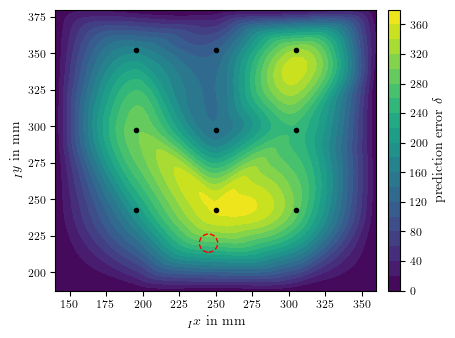

In [63]:
# select specific transformed sample
damage_state = "DS1"
load_case = 814 

df = df_transform_results_experimental
df_sample = df[(df["damage_state"] == damage_state) & (df["loadcase"] == load_case)]

plot_delta_heat_map(df_sample, direction=["desc_x", "desc_y", "desc_xi"], custom_axis_scaling=None,
                    figure_width_cm=15,
                    fn_extension="SPU",
                    show_damage=True)